# CRISPR_Library_analysis

In [ ]:
import pandas as pd
from Bio.Seq import reverse_complement
import matplotlib.pyplot as plt
from gzip import open as gzopen
from collections import Counter
from glob import glob
%matplotlib inline

In [ ]:
def lib_analysis_func(fq_file, grna_design_file):
    #first I merged the fastq files using FLASH
    #now I go through the merged fastq file and extract gRNA target sequences

    left = "CGAAACACCG"
    right = "GTTTTAGAGCTA"
    no_left = []
    no_right = []
    nono = []
    target_seq = []
    print("reading fastq")
    with gzopen(fq_file, 'rt') as f:
        for i, line in enumerate(f):
            if i%3000000 == 0:
                print(i)
            if (i+3)%4 == 0:#why%4?
                read = line.strip()

                r_read = reverse_complement(read)
                if left in read and right in read:
                    target_seq.append(read[read.find(left)+len(left):read.find(right)])
                elif left in r_read and right in r_read:
                    target_seq.append(r_read[r_read.find(left)+len(left):r_read.find(right)])
                else:
                    found = False
                    if left not in read and left not in r_read:
                        no_left.append(read)
                        found = True
                    if right not in read and right not in r_read:
                        no_right.append(read)
                        found = True
                    if not found:
                        nono.append(read)
    print("done")
    total_reads=(i+1)/4 #why %4?
    print(f"no left fragment found: {len(no_left)/total_reads:.1%}")
    print(f"no right fragment found: {len(no_right)/total_reads:.1%}")
    print(f"no left nor right found: {len(nono)/total_reads:.3%}")
    print(f"percentage of reads with left and right: {len(target_seq)/total_reads:.1%}")
    tlens = pd.Series([len(x) for x in target_seq])
    print(f"percent of good reads with target gRNA that is 20bp long: {(tlens==20).sum()/len(tlens):.1%}")

    print("\nDesign file analysis")
    grna_design = pd.read_csv("20190901_Final_CRISPRKO_Library_CHOK1_CHOS_corrected.csv")
    # extract the target gRNA sequence
    grna_design['target_seq'] = grna_design.Sequence.apply(lambda read: read[read.find(left)+len(left):read.find(right)])
    print("see if we have duplicates")
    print(grna_design['target_seq'].value_counts().value_counts())
    unique_genes = grna_design.Name.apply(lambda x: x.split("_")[0]).value_counts()

    ax = unique_genes.value_counts().sort_index().plot(kind='bar', figsize=(20,10), logy=True)
    ax.set_ylabel("Number of unique genes")
    ax.set_xlabel("Number of gRNAs per gene")
    plt.show()

    print(f"Number of unique genes (-1 non targeting control): {len(unique_genes)}")
    print(f"Number of genes with more than 5 gRNA: {sum(unique_genes>5)}")
    print(f"Number of genes with less than 5 gRNA: {sum(unique_genes<5)}")
    print(f"Percentage with 5 gRNA: {sum(unique_genes==5)/len(unique_genes):.1%}")

    print("\nmerging fastq reads with design file")
    target_seq_counter = Counter(target_seq)
    grna_design['target_count'] = grna_design.target_seq.apply(lambda x: target_seq_counter[x])
    print(f"coverage (at least 1 count): {sum(grna_design.target_count>1)/len(grna_design):.2%}")
    print(f"grna with 0 reads: {(grna_design.target_count==0).sum()}")
    a = grna_design.target_count
    print(f"skeq: {a.quantile(0.9)/a.quantile(0.1)}")# a.quantile ?
    return grna_design

In [ ]:
a=lib_analysis_func("Liquidout.extendedFrags.fastq.gz", "20190901_Final_CRISPRKO_Library_CHOK1_CHOS_corrected.csv")

In [ ]:
b=lib_analysis_func("1_ABL-Cell.fastq.gz", "20190901_Final_CRISPRKO_Library_CHOK1_CHOS_corrected.csv")

In [ ]:
c=lib_analysis_func("KO_P0_1.fastq.gz", "20190901_Final_CRISPRKO_Library_CHOK1_CHOS_corrected.csv")

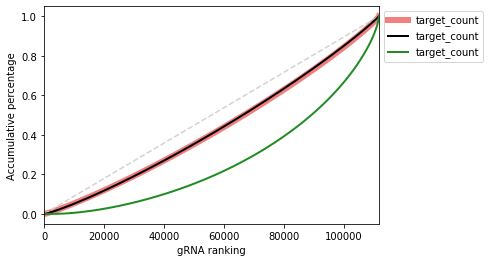

In [ ]:
ax = (b['target_count']/b['target_count'].sum()).sort_values().cumsum().reset_index(drop=True).plot(c='lightcoral', linewidth=6)
ax.plot((0,len(a)), (0,1), c='lightgray', ls='--')
(a['target_count']/a['target_count'].sum()).sort_values().cumsum().reset_index(drop=True).plot(c='black', linewidth=2)
(c['target_count']/c['target_count'].sum()).sort_values().cumsum().reset_index(drop=True).plot(c='forestgreen', linewidth=2)
ax.set_xlabel("gRNA ranking")
ax.set_ylabel("Accumulative percentage")
legend = ax.legend(markerscale=1)
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.savefig("Fig. 1b.png", facecolor='white', dpi=300)
plt.show()
